_Lambda School Data Science - Model Validation_

## Example solution to the Cross-Validation assignment — plus Feature Selection!

See also Sebastian Raschka's example, [Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb).

In [0]:
#!pip install tsfresh
#!pip install seaborn --upgrade

### Here in we pull in all our feature creation functions (from Jake Vanderplas and a few from our cohort)

In [0]:
# We'll modify a project from Python Data Science Handbook by Jake VanderPlas
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic
    
# Predicting Bicycle Traffic

# As an example, let's take a look at whether we can predict the number of 
# bicycle trips across Seattle's Fremont Bridge based on weather, season, 
# and other factors.

# We will join the bike data with another dataset, and try to determine the 
# extent to which weather and seasonal factors—temperature, precipitation, 
# and daylight hours—affect the volume of bicycle traffic through this corridor. 
# Fortunately, the NOAA makes available their daily weather station data 
# (I used station ID USW00024233) and we can easily use Pandas to join 
# the two data sources.


import numpy as np
import pandas as pd
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyRegressor
from datetime import datetime
from datetime import date


def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
  
  
    daily.insert(0, 'ID', range(0, len(daily)))
    daily.insert(0, 'order', range(0, len(daily)))

    return daily

  
def ordinal(daily):
    daily = daily.copy()
    # Add a column of the dates
    daily['date_'] = daily.index
    
    # Date stuff https://docs.python.org/3/library/datetime.html#datetime.date.fromisoformat
    # Add some day context
    daily.insert(0, 'weekday_', daily.date_.apply(lambda x: x.weekday()))
    daily.insert(0, 'dayOfMonth_',  daily.date_.apply(lambda x: x.day))
    daily.insert(0, 'month_',  daily.date_.apply(lambda x: x.month))
    daily.insert(0, 'year_',  daily.date_.apply(lambda x: x.year))  
    
    # Drop date column
    daily = daily.drop(columns='date_')
    
    return daily
  
    
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    
    return X_train, X_test, y_train, y_test

  
  
def one_hot_encoded(X):
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    return X

  

def jake_wrangle(X):  
    X = X.copy()

    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

  

def wrangle(X):
    # From Daniel H (DS1 KotH)
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    X['PRCP_yest'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_ln'] = X['TMIN'] **2
    
    return X

 

In [0]:
# Download and join data into a dataframe
data = load()

In [4]:
data.head()

,order,ID,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-10-04,0,0,3475.0,0,0,0,189,83,65,3521.0
2012-10-05,1,1,3148.0,0,0,0,217,89,57,3475.0
2012-10-06,2,2,2006.0,0,0,0,239,78,51,3148.0
2012-10-07,3,3,2142.0,0,0,0,239,78,13,2006.0
2012-10-08,4,4,3537.0,0,0,0,211,78,19,2142.0


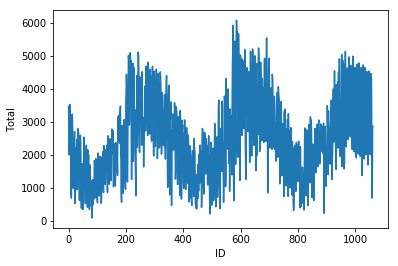

In [5]:
import seaborn as sns
sns.lineplot(data.ID, data.Total)

### This is an example of a pipeline + parameter grid. 

Remember: If your dataset is massive, be sure to take a random subset sample to try fitting with the training data to start getting scores. 

### Benchmark / Baseline using Dummy Regressor in Pipe

In [6]:
%%time
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    DummyRegressor(strategy='mean'))

pipe.fit(X_train, y_train)

### Get the scores with the MAE Function
## Predict with X_test features and Compare predictions to y_test labels
y_pred = pipe.predict(X_train)
dummy_train_score = mean_absolute_error(y_train, y_pred)
print('Dummy Regression Train Score:', dummy_train_score)


## Predict with X_test features and Compare predictions to y_test labels
y_pred = pipe.predict(X_test)
dummy_test_score = mean_absolute_error(y_test, y_pred)
print('Dummy Regression Test Score:', dummy_test_score)


Dummy Regression Train Score: 980.8981106765484
Dummy Regression Test Score: 1341.2051609553478
CPU times: user 20.1 ms, sys: 16 ms, total: 36.1 ms
Wall time: 24.1 ms


In [7]:
%%time

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
RidgeBaseline_train_score = gs.score(X_train, y_train)
print('RidgeBaseline Train Score:', -RidgeBaseline_train_score)

RidgeBaseline_test_score = gs.score(X_test, y_test)
print('RidgeBaseline Test Score:', -RidgeBaseline_test_score)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Cross-Validation Score: 604.6453429336518

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=4, score_func=<function f_regression at 0x7f276dde7d90>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

RidgeBaseline Train Score: 601.7510401226398
RidgeBaseline Test Score: 773.107268536548
CPU times: user 921 ms, sys: 10.2 ms, total: 931 ms
Wall time: 928 ms


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    0.9s finished


###  Apply data `ordinal`

In [8]:
%%time
ordinal_data = ordinal(data)

# Split data into train and test
X_train, X_test, y_train, y_test = split(ordinal_data)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
ord_train_score = gs.score(X_train, y_train)
print('Ordinal Train Score:', -ord_train_score)

ord_test_score = gs.score(X_test, y_test)
print('Ordinal Test Score:', -ord_test_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 39 candidates, totalling 117 fits

Cross-Validation Score: 389.2116166662251

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=5, score_func=<function f_regression at 0x7f276dde7d90>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Ordinal Train Score: 385.55035508465824
Ordinal Test Score: 448.71439473552834
CPU times: user 1.49 s, sys: 16 ms, total: 1.51 s
Wall time: 1.5 s


[Parallel(n_jobs=1)]: Done 117 out of 117 | elapsed:    1.5s finished


### Apply `one_hot_encoded` (classmates function)

In [9]:
#%%time
one_hot_data = one_hot_encoded(data)

# Split data into train and test
X_train, X_test, y_train, y_test = split(one_hot_data)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
oh_train_score = gs.score(X_train, y_train)
print('Train Score:', -oh_train_score)

oh_test_score = gs.score(X_test, y_test)
print('Test Score:', -oh_test_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 87 candidates, totalling 261 fits

Cross-Validation Score: 317.0293417197573

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=24, score_func=<function f_regression at 0x7f276dde7d90>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Train Score: 291.1151670177737
Test Score: 625.2713329002021


[Parallel(n_jobs=1)]: Done 261 out of 261 | elapsed:    5.2s finished


In [10]:
print('Ordinal Train Score:', -ord_train_score)
print('Ordinal Test Score:', -ord_test_score)
print('\n')
print('One-Hot Train Score:', -oh_train_score)
print('One-Hot Test Score:', -oh_test_score)

Ordinal Train Score: 385.55035508465824
Ordinal Test Score: 448.71439473552834


One-Hot Train Score: 291.1151670177737
One-Hot Test Score: 625.2713329002021


###  Just feature Wrangling

In [11]:
%%time
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Do the same wrangling to X_train and X_test
X_train = wrangle(X_train)
X_test = wrangle(X_test)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
RRtrain_score = gs.score(X_train, y_train)
print('Just Wrangling Train Score:', -RRtrain_score)

RRtest_score = gs.score(X_test, y_test)
print('Just Wrangling Test Score:', -RRtest_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 51 candidates, totalling 153 fits

Cross-Validation Score: 595.6499492839174

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=16, score_func=<function f_regression at 0x7f276dde7d90>)), ('ridge', Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Just Wrangling Train Score: 590.9809720746895
Just Wrangling Test Score: 768.3761136981898
CPU times: user 3.24 s, sys: 1.93 s, total: 5.17 s
Wall time: 2.63 s


[Parallel(n_jobs=1)]: Done 153 out of 153 | elapsed:    2.5s finished


### Comparing 3 seperate runs. 

In [12]:
# Comparing 1 set of variables for each

print('Dummy Regression Train Score:', dummy_train_score)
print('Dummy Regression Test Score:', dummy_test_score)
print('\n')
print('RidgeBaseline Train Score:', -RidgeBaseline_train_score)
print('RidgeBaseline Test Score:', -RidgeBaseline_test_score)
print('\n')
print('Just Ordinal Train Score:', -ord_train_score)
print('Just Ordinal Test Score:', -ord_test_score)
print('\n')
print('Just One-Hot Train Score:', -oh_train_score)
print('Just One-Hot Test Score:', -oh_test_score)
print('\n')
print('Just Wrangling Train Score:', -RRtrain_score)
print('Just Wrangling Test Score:', -RRtest_score)

Dummy Regression Train Score: 980.8981106765484
Dummy Regression Test Score: 1341.2051609553478


RidgeBaseline Train Score: 601.7510401226398
RidgeBaseline Test Score: 773.107268536548


Just Ordinal Train Score: 385.55035508465824
Just Ordinal Test Score: 448.71439473552834


Just One-Hot Train Score: 291.1151670177737
Just One-Hot Test Score: 625.2713329002021


Just Wrangling Train Score: 590.9809720746895
Just Wrangling Test Score: 768.3761136981898


### Combine all 3 feature engineering sets. 

In [13]:
%%time
ordinal_data = ordinal(data)
ord_oh_data = one_hot_encoded(ordinal_data)
wrangled_oh_ord_data = wrangle(ord_oh_data)

# Split data into train and test
X_train, X_test, y_train, y_test = split(wrangled_oh_ord_data)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
fe_train_score = gs.score(X_train, y_train)
print('Feature Engineered Train Score:', -fe_train_score)

fe_test_score = gs.score(X_test, y_test)
print('Feature Engineered Test Score:', -fe_test_score)

Fitting 3 folds for each of 123 candidates, totalling 369 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Cross-Validation Score: 297.2903366179876

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=33, score_func=<function f_regression at 0x7f276dde7d90>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Feature Engineered Train Score: 272.8314219289632
Feature Engineered Test Score: 333.87956324859124
CPU times: user 10.9 s, sys: 7.61 s, total: 18.5 s
Wall time: 9.36 s


[Parallel(n_jobs=1)]: Done 369 out of 369 | elapsed:    9.2s finished


In [14]:

fe_train_score = gs.score(X_train, y_train)
print('Feature Engineered Train Score:', -fe_train_score)

fe_test_score = gs.score(X_test, y_test)
print('Feature Engineered Test Score:', -fe_test_score)

Feature Engineered Train Score: 272.8314219289632
Feature Engineered Test Score: 333.87956324859124


In [15]:
%%time
ordinal_data = ordinal(data)
ord_oh_data = one_hot_encoded(ordinal_data)
wrangled_oh_ord_data = wrangle(ord_oh_data)

# Split data into train and test
X_train, X_test, y_train, y_test = split(wrangled_oh_ord_data)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
fe_train_score = gs.score(X_train, y_train)
print('Feature Engineered Train Score:', -fe_train_score)

fe_test_score = gs.score(X_test, y_test)
print('Feature Engineered Test Score:', -fe_test_score)

Fitting 3 folds for each of 123 candidates, totalling 369 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Cross-Validation Score: 297.2903366179876

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=33, score_func=<function f_regression at 0x7f276dde7d90>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Feature Engineered Train Score: 272.8314219289632
Feature Engineered Test Score: 333.87956324859124
CPU times: user 10.8 s, sys: 7.65 s, total: 18.5 s
Wall time: 9.34 s


[Parallel(n_jobs=1)]: Done 369 out of 369 | elapsed:    9.1s finished


### Notes on Pipeline / GridScore

#### Then we can get the final test score (using MAE function)

Using gs.predict calls all the grid score fit/transforms and applies them to our X_test data in this case. 

Then we can calculate our score useing those test predictions. 

In [16]:
# Predict with X_test features
y_pred = gs.predict(X_test)

# Compare predictions to y_test labels
test_score = mean_absolute_error(y_test, y_pred)
print('Test Score:', test_score)

Test Score: 333.87956324859124


#### Or use the GridSearch's `score` method to get the final test score. 

This method just generates the test predictions and scores them, returning the (negative) test score to you. So you apply the negative symbol to flip the sign from negative to positive. 

In [17]:
train_score = gs.score(X_train, y_train)
print('Train Score:', -train_score)

# Or use the grid search's score method, 
# which combines these steps
test_score = gs.score(X_test, y_test)

print('Test Score:', -test_score)

Train Score: 272.8314219289632
Test Score: 333.87956324859124


In [0]:
'''def vary_scale(typ): 
  if typ=='robust': return RobustScaler
  elif typ=='standard': return StandardScaler
  else: Fail

pipe = Pipeline(steps=[  ... , ('scale', FunctionTransformer(vary_scale)), ... ])

param_grid = { 
    ... , 
    FunctionTransformer'vary_scale__choice': ['robust', 'standard'],
    ... }

search = GridSearchCV(pipe, param_grid, ...)''';

### Now we can explore and see what features we actually ended up selecting. 

In [19]:
# Which features were selected?
# 'selectkbest' is the autogenerated name of the SelectKBest() function in the pipeline
selector = gs.best_estimator_.named_steps['selectkbest']
all_names = X_train.columns

# get_support returns a mask of the columns in True / False
selected_mask = selector.get_support()
# Passing the boolean list as the column names creates a 
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print()
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
year_
weekday_
order
ID
PRCP
TMAX
TMIN
AWND
Total_yesterday
Mon
Tue
Wed
Thu
Sat
Sun
holiday
Jan
Feb
Mar
May
Jun
Jul
Aug
Nov
Dec
daylight_hrs
Temp (C)
dry day
annual
PRCP_yest
Windchill
Rl_Cold
TMIN_ln

Features not selected:
month_
dayOfMonth_
SNOW
SNWD
Fri
Apr
Sep
Oct


## Now Lets Try with Tsfresh (Relevant Time Feature Augmentor)

In [20]:
data.head()

,order,ID,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-10-04,0,0,3475.0,0,0,0,189,83,65,3521.0
2012-10-05,1,1,3148.0,0,0,0,217,89,57,3475.0
2012-10-06,2,2,2006.0,0,0,0,239,78,51,3148.0
2012-10-07,3,3,2142.0,0,0,0,239,78,13,2006.0
2012-10-08,4,4,3537.0,0,0,0,211,78,19,2142.0


In [0]:
# Split data into train and test
X_train, X_test, y_train, y_test = split(wrangled_oh_ord_data)

In [22]:
X_train.head()

,year_,month_,dayOfMonth_,weekday_,order,ID,PRCP,SNOW,SNWD,TMAX,...,Nov,Dec,daylight_hrs,Temp (C),dry day,annual,PRCP_yest,Windchill,Rl_Cold,TMIN_ln
2012-10-04,2012,10,4,3,0,0,0.0,0,0,18.9,...,0.0,0.0,11.219142,13.60,1,0.000000,0.115555,11.462882,7.231732,68.89
2012-10-05,2012,10,5,4,1,1,0.0,0,0,21.7,...,0.0,0.0,11.161038,15.30,1,0.002740,0.000000,15.966438,6.429757,79.21
2012-10-06,2012,10,6,5,2,2,0.0,0,0,23.9,...,0.0,0.0,11.103056,15.85,1,0.005479,0.000000,18.006641,5.846311,60.84
2012-10-07,2012,10,7,6,3,3,0.0,0,0,23.9,...,0.0,0.0,11.045208,15.85,1,0.008219,0.000000,28.683555,-0.085308,60.84
2012-10-08,2012,10,8,0,4,4,0.0,0,0,21.1,...,0.0,0.0,10.987503,14.45,1,0.010959,0.000000,23.424626,1.436319,60.84


In [0]:
# Find all the features, even the irrelevant ones.
%%time
from tsfresh.transformers import RelevantFeatureAugmenter
from tsfresh import extract_features

extracted_features = extract_features(wrangled_oh_ord_data, column_id="annual", column_sort="ID")

from tsfresh.utilities.dataframe_functions import impute

features = impute(extracted_features)

Feature Extraction:   0%|          | 0/5 [00:00<?, ?it/s]

In [0]:

from tsfresh import extract_relevant_features
features_filtered_direct = extract_relevant_features(X_train, y_train,
                                                     column_id='annual', column_sort='ID')


features_filtered_direct

In [81]:
df_ts, y = y_train
X = X_train



# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RelevantFeatureAugmenter(column_id='id'),
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

pipe.get_params(augmenter__timeseries_container= df_ts)

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X, y)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


ValueError: ignored

In [0]:
# Predict with X_test features
y_pred = gs.predict(X_test)

# Compare predictions to y_test labels
test_score = mean_absolute_error(y_test, y_pred)
print('Test Score:', test_score)

## BONUS: Recursive Feature Elimination!

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

In [8]:
from sklearn.feature_selection import RFECV

X_train_scaled = RobustScaler().fit_transform(X_train)
rfe = RFECV(Ridge(alpha=1.0), scoring='neg_mean_absolute_error', cv=3)
X_train_subset = rfe.fit_transform(X_train_scaled, y_train)

all_names = X_train.columns
selected_mask = rfe.support_
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print()
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
PRCP
TMAX
TMIN
AWND
Total_yesterday
Mon
Tue
Wed
Thu
Fri
Sat
Sun
holiday
daylight_hrs
Temp (C)
dry day
Windchill
Rl_Cold
TMIN_ln
Mar
May
Jun
Oct
Dec

Features not selected:
SNOW
SNWD
annual
PRCP_yest
Jan
Feb
Apr
Jul
Aug
Sep
Nov


In [0]:
X_train_subset = pd.DataFrame(X_train_subset, columns=selected_names)

In [0]:
X_test_subset = rfe.transform(X_test)
X_test_subset = pd.DataFrame(X_test_subset, columns=selected_names)

In [11]:
print(X_train.shape, X_train_subset.shape, X_test.shape, X_test_subset.shape)

(963, 35) (963, 24) (100, 35) (100, 24)


# RFE again, but with polynomial features and interaction terms!

### Apply a Polynomial Transformation

In [27]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_polynomial = poly.fit_transform(X_train)

print(X_train.shape, X_train_polynomial.shape)

(963, 35) (963, 666)


### Apply a Scaler & RFECV

In [0]:
from sklearn.feature_selection import RFECV

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_polynomial)

rfe = RFECV(Ridge(alpha=1.0), scoring='neg_mean_absolute_error', 
            step=10, cv=3, verbose=1)

X_train_subset = rfe.fit_transform(X_train_scaled, y_train)

### Look at all of those new features!


In [0]:
all_names = poly.get_feature_names(X_train.columns)
selected_mask = rfe.support_
selected_names = [name for name, selected in zip(all_names, selected_mask) if selected]

print(f'{rfe.n_features_} Features selected:')
for name in selected_names:
    print(name)

### Now we can experiment with mulitple ridge settings for selecting features. 

In [30]:
# Define an estimator and param_grid

ridge = Ridge()

param_grid = {
    'alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(ridge, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train_subset, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()

Fitting 3 folds for each of 3 candidates, totalling 9 fits

Cross-Validation Score: 247.80985367683917

Best estimator: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished


In [0]:
# Do the same transformations to X_test (Applying the same transformations to each set so we can check the test scores)
X_test_polynomial = poly.transform(X_test)
X_test_scaled = scaler.transform(X_test_polynomial)
X_test_subset = rfe.transform(X_test_scaled)

# Use the grid search's score method with X_test_subset
test_score = gs.score(X_test_subset, y_test)
print('Test Score:', -test_score)

###  Exploring other regression


Automatically created module for IPython interactive environment
(array([[1958.16666667],
       [1958.25      ],
       [1958.33333333],
       [1958.5       ],
       [1958.58333333],
       [1958.66666667],
       [1958.83333333],
       [1958.91666667],
       [1959.        ],
       [1959.08333333],
       [1959.16666667],
       [1959.25      ],
       [1959.33333333],
       [1959.41666667],
       [1959.5       ],
       [1959.58333333],
       [1959.66666667],
       [1959.75      ],
       [1959.83333333],
       [1959.91666667],
       [1960.        ],
       [1960.08333333],
       [1960.16666667],
       [1960.25      ],
       [1960.33333333],
       [1960.41666667],
       [1960.5       ],
       [1960.58333333],
       [1960.66666667],
       [1960.75      ],
       [1960.83333333],
       [1960.91666667],
       [1961.        ],
       [1961.08333333],
       [1961.16666667],
       [1961.25      ],
       [1961.33333333],
       [1961.41666667],
       [1961.5       ]

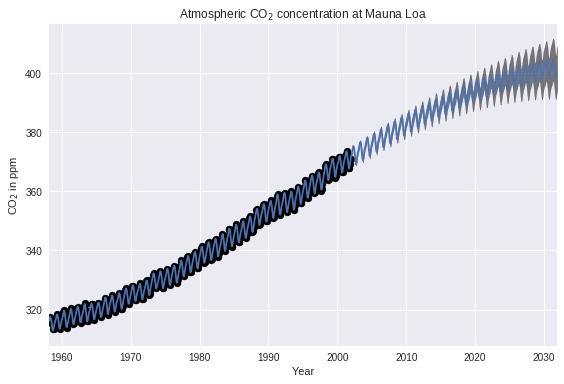

In [83]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

from __future__ import division, print_function

import numpy as np

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

print(__doc__)


def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs


X, y = load_mauna_loa_atmospheric_co2()

print(load_mauna_loa_atmospheric_co2())

# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer=None, normalize_y=True)
gp.fit(X, y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, np.inf))  # noise terms
kernel = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True)
gp.fit(X, y)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# Illustration
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

In [0]:

X, y = load_robot_execution_failures()

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from tsfresh.examples import load_robot_execution_failures
from tsfresh.transformers import RelevantFeatureAugmenter
import tsfresh as tfsh


pipeline = Pipeline([('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='time')),
            ('classifier', RandomForestClassifier())])

df_ts, y = load_robot_execution_failures()
X = pd.DataFrame(index=y.index)

pipeline.set_params(augmenter__timeseries_container=df_ts)
pipeline.fit(X, y)

In [2]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, \
    load_robot_execution_failures
download_robot_execution_failures()
df_ts, y = load_robot_execution_failures()
X = pd.DataFrame(index=y.index)

print (df_ts.shape)
print (y.shape)
print (X.shape)

ModuleNotFoundError: ignored